# Energetics of the EN4 dataset

Aim: The main aim of this analysis is to investigate how the excess of energy taken up by the oceans affect the heat versus the APE

In [38]:
import numpy as np
import numpy.ma as ma
import gsw
from gsw_gammat_analytic_CT_exact import *
from gsw_gammat_analytic_CT_fast import *
from gsw_gammat_analytic_CT import *
import time
import os
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import netCDF4 as nc4

In [39]:
# Define analytical Lorenz reference density profile
# --------------------------------------------------
# Set values of coefficients
# --------------------------------------------------
a = 4.56016575
b = -1.24898501
c = 0.00439778209
d = 1030.99373
e = 8.32218903 

# Define gravity 
grav = 9.81

# Define analytical expressions for reference density and pressure
# ----------------------------------------------------------------
rhor = lambda z: a/(b+1)*(z+e)**(b+1) + c*z + d  ## This analytical density profile fitted on the WOCE dataset.
pr = lambda z: grav * (a/((b+1)*(b+2))*((z+e)**(b+2)) + c/2.*z**2 + d*z - a/((b+1)*(b+2))*e**(b+2))/1e4

filtIO = np.load('IO_filter.npy', allow_pickle = True)
filtPO = np.load('IO_filter.npy', allow_pickle = True)



In [34]:
# Locate the data and define rules for constructing data file names
# datadir = 'C:\Users\Linne\Documents\Github\APE-Estimates\Data'
# datadir = '/Users/remitailleux/Documents/DATASETS/EN4_DATA'
rootname = 'EN.4.2.2.f.analysis.g10.'

# Open a random file to extract relevant information and put the info into 'data' 
data = xr.open_dataset(f'Data/{rootname}195001.nc')
# fields = nc4.Dataset(f'{datadir}/{1950}/{rootname}195001.nc')


# Upload depth bounds and compute layer thickness
ZB = data.depth_bnds.to_numpy().squeeze() 
# ZB = fields.variables['depth_bnds'][:]
e3t = ZB[:,1] - ZB[:,0]
print(e3t.shape)
print(e3t) 

# Upldate longitude, latitude, and depths of temperature points
lon1D = data.lon.to_numpy()
# lon1D = fields.variables['lon'][:]
npi = len(lon1D)
lat1D = data.lat.to_numpy()
# lat1D = fields.variables['lat'][:]
npj = len(lat1D) 
z1D = data.depth.to_numpy() 
# z1D = fields.variables['depth'][:]
npk = len(z1D) 
print([npk,npj,npi])

# load practical salinity, primarily to get the mask
SP = data.salinity.to_masked_array().squeeze()

# Define 3D version of depths and compute the reference pressure
z3d = np.zeros([npk,npj,npi]) 
for k in range(0,npk):
    z3d[k, :, :] = z1D[k] 
prz = pr(z3d) 

# Compare horizontal area for each elements
ra = 6.371e6
dx = ra*(lon1D[1]-lon1D[0])*np.pi/180
print(f'length of dx={dx}')

#area = np.empty((npi,npj)) 
#area[:] = ra*dx*(np.sin((lat1D[:]+0.5)*np.pi/180) - np.sin((lat1D[:]-0.5)*np.pi/180))
#print(area.shape) 
#area = np.transpose(area) 
#print(area.shape) 

area = ra*dx*(np.sin((lat1D[:]+0.5)*np.pi/180) - np.sin((lat1D[:]-0.5)*np.pi/180))*np.ones(npi)[:,np.newaxis]
print(area.shape)
print(np.sum(area))

# Compute volume
dV = area.T*e3t[:, np.newaxis, np.newaxis]
print(np.sum(dV)) 

V_ijk = ma.array(dV,mask = SP.mask)
print(ma.sum(V_ijk))
V_total = ma.sum(V_ijk)
weights = V_ijk/V_total
print([V_total,ma.sum(weights)])

print(weights.shape)

# Define cp0
cp0 = gsw.energy.enthalpy(35.,20.,0.)/20.
print([cp0,3991.86795711963])

(42,)
[ 10.0475    10.068301  10.0982    10.1413    10.2033    10.292297
  10.420204  10.604195  10.868401  11.247604  11.791199  12.569702
  13.682297  15.267395  17.516998  20.690811  25.132095  31.276794
  39.645218  50.8013    65.25928   83.32501  104.900696 129.3208
 155.3393   181.33575  205.69604  227.18677  245.15869  259.526
 270.6034   278.90747  285.0017   289.40527  292.5515   294.78076
 296.3518   297.45386  298.2256   298.76416  299.13965  299.40137 ]
[42, 173, 360]
length of dx=111194.92664455873
(360, 173)
508415367427200.0
2.7962845208496005e+18
1.5142117733078182e+18
[1.5142117733078182e+18, 0.21159126913564688]
(42, 173, 360)
[3991.86795711963, 3991.86795711963]


# Temporal Loop

In [35]:
# Define month strings
months = ['01','02','03','04','05','06','07','08','09','10','11','12']

# Define starting and end year
start_year = 1960
end_year = 2020 
npoints = (end_year-start_year + 1)*12
ncounter = 0

CT_mean_time_series = np.zeros(npoints)
PT_mean_time_series = np.zeros(npoints)
CTR_mean_time_series = np.zeros(npoints) 
APE_mean_time_series = np.zeros(npoints)
APE_IO_mean_time_series = np.zeros(npoints)
APE_PO_mean_time_series = np.zeros(npoints)
APE_bis_time_series = np.zeros(npoints) 
APE_negative_time_series = np.zeros(npoints)

# Start of temporal loop 

for year in range(start_year,end_year+1):
    decade = (year//10)*10  
    for month in months:
        print(ncounter) 
        
        start = time.time()
        
        # define filename and open the data set using xarray, storing the result into 'data' 
        filename = f'Data/{rootname}{year}{month}.nc'
        print(filename)
        data = xr.open_dataset(filename)
        # fields = nc4.Dataset(filename)
        
        # load practical salinity
        SP = data.salinity.to_masked_array().squeeze()
        # SP = fields.variables['salinity'][0,:]
        # load potential temperature and convert it from Kelvins to Celsius
        PT = data.temperature.to_masked_array().squeeze() - 273.15
        # PT = fields.variables['temperature'][0,:] - 273.15
        
        #calculating reference salinity from practical salinity
        SR = gsw.conversions.SR_from_SP(SP)
        #calculating conservative temperature from SR and PT  
        CT = gsw.conversions.CT_from_pt(SR, PT)
            
        # calculating zref, pref
        gammat, zref, pref, sigref = gsw_gammat_analytic_CT_fast(SR, CT)
        
        # calculating enthalpies
        href = gsw.energy.enthalpy(SR, CT, pref)
        h = gsw.energy.enthalpy(SR, CT, prz)
   
        # Calculate reference CT and APE density 
        CTR = (href - grav*zref)/cp0 
        APE = h - href - grav*(z3d-zref) 
        
        # Copy the APE array to test the impact of remaining negative APE values 
        APE_bis = np.ma.copy(APE)
        APE_bis = np.ma.where(APE_bis < 0,0, APE_bis) 
        
        # mean temperature
        mean_CT = ma.sum(CT*weights)
        CT_mean_time_series[ncounter] = mean_CT
        
        mean_PT = ma.sum(PT*weights)
        PT_mean_time_series[ncounter] = mean_PT
        
        mean_CTR = ma.sum(CTR*weights)
        CTR_mean_time_series[ncounter] = mean_CTR 
        
        mean_APE = ma.sum(APE*weights)
        APE_mean_time_series[ncounter] = mean_APE 
        
        mean_APE_IO = ma.sum(APE*weights*filtIO)
        mean_APE_PO = ma.sum(APE*weights*filtPO)
        APE_IO_mean_time_series[ncounter] = mean_APE_IO 
        APE_PO_mean_time_series[ncounter] = mean_APE_PO
        
        mean_APE_bis = ma.sum(APE_bis*weights)
        APE_bis_time_series[ncounter] = mean_APE_bis 
        
        
        APE_negative_time_series[ncounter] = np.sum(APE<0) 
        print(APE_negative_time_series[ncounter]) 
        
        end = time.time() 
        print(f'time iteration = {end-start}')
        print(f'mean temperature = {mean_CT}')
        ncounter = ncounter + 1

0
Data/EN.4.2.2.f.analysis.g10.196001.nc
1.0
time iteration = 6.764486074447632
mean temperature = 0.7243697575060839
1
Data/EN.4.2.2.f.analysis.g10.196002.nc
1.0
time iteration = 6.606984853744507
mean temperature = 0.7287239404358752
2
Data/EN.4.2.2.f.analysis.g10.196003.nc
5.0
time iteration = 6.835094690322876
mean temperature = 0.7286649918083968
3
Data/EN.4.2.2.f.analysis.g10.196004.nc
2.0
time iteration = 6.396057844161987
mean temperature = 0.7278684656680724
4
Data/EN.4.2.2.f.analysis.g10.196005.nc
1.0
time iteration = 6.381096363067627
mean temperature = 0.7249737885680406
5
Data/EN.4.2.2.f.analysis.g10.196006.nc
3.0
time iteration = 6.533891439437866
mean temperature = 0.7217415156394801
6
Data/EN.4.2.2.f.analysis.g10.196007.nc
0.0
time iteration = 6.421797752380371
mean temperature = 0.7199708946553728
7
Data/EN.4.2.2.f.analysis.g10.196008.nc
2.0
time iteration = 6.29040789604187
mean temperature = 0.7171205629334135
8
Data/EN.4.2.2.f.analysis.g10.196009.nc
2.0
time iterati

2.0
time iteration = 6.3839240074157715
mean temperature = 0.7152795186054737
70
Data/EN.4.2.2.f.analysis.g10.196511.nc
1.0
time iteration = 6.393223762512207
mean temperature = 0.7167851537916582
71
Data/EN.4.2.2.f.analysis.g10.196512.nc
1.0
time iteration = 6.345477342605591
mean temperature = 0.7200221576132719
72
Data/EN.4.2.2.f.analysis.g10.196601.nc
0.0
time iteration = 6.307815790176392
mean temperature = 0.727310716244142
73
Data/EN.4.2.2.f.analysis.g10.196602.nc
2.0
time iteration = 6.3052215576171875
mean temperature = 0.7298549693722101
74
Data/EN.4.2.2.f.analysis.g10.196603.nc
1.0
time iteration = 6.340245246887207
mean temperature = 0.7300817776269782
75
Data/EN.4.2.2.f.analysis.g10.196604.nc
3.0
time iteration = 6.287195682525635
mean temperature = 0.7295706363001137
76
Data/EN.4.2.2.f.analysis.g10.196605.nc
0.0
time iteration = 6.385910749435425
mean temperature = 0.7265289111945592
77
Data/EN.4.2.2.f.analysis.g10.196606.nc
1.0
time iteration = 6.505052089691162
mean tem

2.0
time iteration = 6.326361417770386
mean temperature = 0.7210366323621885
139
Data/EN.4.2.2.f.analysis.g10.197108.nc
2.0
time iteration = 6.316587209701538
mean temperature = 0.7188663116948122
140
Data/EN.4.2.2.f.analysis.g10.197109.nc
0.0
time iteration = 6.2604851722717285
mean temperature = 0.7159701624043603
141
Data/EN.4.2.2.f.analysis.g10.197110.nc
2.0
time iteration = 6.305413007736206
mean temperature = 0.7160224749178442
142
Data/EN.4.2.2.f.analysis.g10.197111.nc
2.0
time iteration = 6.49481725692749
mean temperature = 0.7172093003976838
143
Data/EN.4.2.2.f.analysis.g10.197112.nc
3.0
time iteration = 6.401001691818237
mean temperature = 0.718341373162177
144
Data/EN.4.2.2.f.analysis.g10.197201.nc
0.0
time iteration = 6.331454277038574
mean temperature = 0.7241013959990061
145
Data/EN.4.2.2.f.analysis.g10.197202.nc
2.0
time iteration = 6.279935598373413
mean temperature = 0.7274091177610476
146
Data/EN.4.2.2.f.analysis.g10.197203.nc
0.0
time iteration = 6.404776573181152
me

2.0
time iteration = 6.412959337234497
mean temperature = 0.7270803844853359
208
Data/EN.4.2.2.f.analysis.g10.197705.nc
0.0
time iteration = 6.560867547988892
mean temperature = 0.726816022576207
209
Data/EN.4.2.2.f.analysis.g10.197706.nc
0.0
time iteration = 6.430567264556885
mean temperature = 0.722806413980159
210
Data/EN.4.2.2.f.analysis.g10.197707.nc
2.0
time iteration = 6.344801902770996
mean temperature = 0.7200537559531571
211
Data/EN.4.2.2.f.analysis.g10.197708.nc
1.0
time iteration = 6.584701776504517
mean temperature = 0.7193728612368603
212
Data/EN.4.2.2.f.analysis.g10.197709.nc
6.0
time iteration = 6.371735334396362
mean temperature = 0.7206561072378617
213
Data/EN.4.2.2.f.analysis.g10.197710.nc
0.0
time iteration = 6.432971954345703
mean temperature = 0.7184718340270679
214
Data/EN.4.2.2.f.analysis.g10.197711.nc
2.0
time iteration = 6.396361827850342
mean temperature = 0.7192645280258143
215
Data/EN.4.2.2.f.analysis.g10.197712.nc
2.0
time iteration = 6.374003648757935
mea

1.0
time iteration = 6.68481707572937
mean temperature = 0.7244351896356105
277
Data/EN.4.2.2.f.analysis.g10.198302.nc
3.0
time iteration = 6.5455522537231445
mean temperature = 0.7236075186676549
278
Data/EN.4.2.2.f.analysis.g10.198303.nc
0.0
time iteration = 6.607909679412842
mean temperature = 0.7277959157709283
279
Data/EN.4.2.2.f.analysis.g10.198304.nc
1.0
time iteration = 6.613735675811768
mean temperature = 0.7267327185469681
280
Data/EN.4.2.2.f.analysis.g10.198305.nc
4.0
time iteration = 6.755059003829956
mean temperature = 0.7261831285596523
281
Data/EN.4.2.2.f.analysis.g10.198306.nc
0.0
time iteration = 6.773471117019653
mean temperature = 0.7255675496511652
282
Data/EN.4.2.2.f.analysis.g10.198307.nc
2.0
time iteration = 6.710899114608765
mean temperature = 0.7218939542963612
283
Data/EN.4.2.2.f.analysis.g10.198308.nc
3.0
time iteration = 6.520638942718506
mean temperature = 0.7165718166384222
284
Data/EN.4.2.2.f.analysis.g10.198309.nc
1.0
time iteration = 6.483818769454956
m

1.0
time iteration = 6.532109975814819
mean temperature = 0.7190448017788357
346
Data/EN.4.2.2.f.analysis.g10.198811.nc
2.0
time iteration = 6.548844814300537
mean temperature = 0.7195731590765324
347
Data/EN.4.2.2.f.analysis.g10.198812.nc
1.0
time iteration = 6.523758888244629
mean temperature = 0.7243593918185182
348
Data/EN.4.2.2.f.analysis.g10.198901.nc
0.0
time iteration = 6.64985990524292
mean temperature = 0.7294970890064651
349
Data/EN.4.2.2.f.analysis.g10.198902.nc
1.0
time iteration = 6.807471752166748
mean temperature = 0.7305001474734735
350
Data/EN.4.2.2.f.analysis.g10.198903.nc
2.0
time iteration = 6.482040643692017
mean temperature = 0.7294548846888937
351
Data/EN.4.2.2.f.analysis.g10.198904.nc
1.0
time iteration = 6.451803207397461
mean temperature = 0.7263502066400328
352
Data/EN.4.2.2.f.analysis.g10.198905.nc
0.0
time iteration = 6.513029098510742
mean temperature = 0.7241282048153618
353
Data/EN.4.2.2.f.analysis.g10.198906.nc
1.0
time iteration = 6.570073366165161
me

1.0
time iteration = 6.636688232421875
mean temperature = 0.718027748747561
415
Data/EN.4.2.2.f.analysis.g10.199408.nc
2.0
time iteration = 6.554330587387085
mean temperature = 0.7173592303881827
416
Data/EN.4.2.2.f.analysis.g10.199409.nc
2.0
time iteration = 6.6058337688446045
mean temperature = 0.7151294530841477
417
Data/EN.4.2.2.f.analysis.g10.199410.nc
1.0
time iteration = 6.548705339431763
mean temperature = 0.7160129747580762
418
Data/EN.4.2.2.f.analysis.g10.199411.nc
0.0
time iteration = 6.549436330795288
mean temperature = 0.7171489316186767
419
Data/EN.4.2.2.f.analysis.g10.199412.nc
1.0
time iteration = 6.677802085876465
mean temperature = 0.7218075439125065
420
Data/EN.4.2.2.f.analysis.g10.199501.nc
0.0
time iteration = 6.485785722732544
mean temperature = 0.7271978931918022
421
Data/EN.4.2.2.f.analysis.g10.199502.nc
2.0
time iteration = 6.537707090377808
mean temperature = 0.7267598364844566
422
Data/EN.4.2.2.f.analysis.g10.199503.nc
1.0
time iteration = 6.729386568069458
m

2.0
time iteration = 6.633747100830078
mean temperature = 0.728161985570571
484
Data/EN.4.2.2.f.analysis.g10.200005.nc
3.0
time iteration = 6.613212585449219
mean temperature = 0.7277384269937155
485
Data/EN.4.2.2.f.analysis.g10.200006.nc
0.0
time iteration = 6.590700387954712
mean temperature = 0.7264944268441379
486
Data/EN.4.2.2.f.analysis.g10.200007.nc
1.0
time iteration = 6.588554382324219
mean temperature = 0.7250124305551208
487
Data/EN.4.2.2.f.analysis.g10.200008.nc
3.0
time iteration = 6.573709964752197
mean temperature = 0.7237853764851994
488
Data/EN.4.2.2.f.analysis.g10.200009.nc
3.0
time iteration = 6.613879680633545
mean temperature = 0.7213938936866485
489
Data/EN.4.2.2.f.analysis.g10.200010.nc
3.0
time iteration = 6.504870414733887
mean temperature = 0.719672280592423
490
Data/EN.4.2.2.f.analysis.g10.200011.nc
1.0
time iteration = 6.5183422565460205
mean temperature = 0.7194414596232356
491
Data/EN.4.2.2.f.analysis.g10.200012.nc
0.0
time iteration = 6.480201482772827
me

3.0
time iteration = 6.623867511749268
mean temperature = 0.7238473276917398
553
Data/EN.4.2.2.f.analysis.g10.200602.nc
3.0
time iteration = 6.576306343078613
mean temperature = 0.7257536748256589
554
Data/EN.4.2.2.f.analysis.g10.200603.nc
0.0
time iteration = 6.541452169418335
mean temperature = 0.7273853058220702
555
Data/EN.4.2.2.f.analysis.g10.200604.nc
2.0
time iteration = 6.548509836196899
mean temperature = 0.7285504999876468
556
Data/EN.4.2.2.f.analysis.g10.200605.nc
3.0
time iteration = 6.842727184295654
mean temperature = 0.7278642467920199
557
Data/EN.4.2.2.f.analysis.g10.200606.nc
1.0
time iteration = 6.64571213722229
mean temperature = 0.7275647988010155
558
Data/EN.4.2.2.f.analysis.g10.200607.nc
3.0
time iteration = 6.726067066192627
mean temperature = 0.7254568818233035
559
Data/EN.4.2.2.f.analysis.g10.200608.nc
1.0
time iteration = 6.776162385940552
mean temperature = 0.7249300020397761
560
Data/EN.4.2.2.f.analysis.g10.200609.nc
1.0
time iteration = 6.608290910720825
me

0.0
time iteration = 6.431121349334717
mean temperature = 0.727059875371612
622
Data/EN.4.2.2.f.analysis.g10.201111.nc
4.0
time iteration = 6.3882739543914795
mean temperature = 0.726112592642835
623
Data/EN.4.2.2.f.analysis.g10.201112.nc
1.0
time iteration = 6.4530229568481445
mean temperature = 0.7294064555933518
624
Data/EN.4.2.2.f.analysis.g10.201201.nc
1.0
time iteration = 6.4477362632751465
mean temperature = 0.7332109199551274
625
Data/EN.4.2.2.f.analysis.g10.201202.nc
0.0
time iteration = 6.467733383178711
mean temperature = 0.7358607089283584
626
Data/EN.4.2.2.f.analysis.g10.201203.nc
0.0
time iteration = 6.371525526046753
mean temperature = 0.7364036578137144
627
Data/EN.4.2.2.f.analysis.g10.201204.nc
2.0
time iteration = 6.360228538513184
mean temperature = 0.7345738659101009
628
Data/EN.4.2.2.f.analysis.g10.201205.nc
1.0
time iteration = 6.39860200881958
mean temperature = 0.7326834138787223
629
Data/EN.4.2.2.f.analysis.g10.201206.nc
2.0
time iteration = 6.641335964202881
m

2.0
time iteration = 6.457047700881958
mean temperature = 0.7302146988818127
691
Data/EN.4.2.2.f.analysis.g10.201708.nc
0.0
time iteration = 6.464938640594482
mean temperature = 0.7292174979704193
692
Data/EN.4.2.2.f.analysis.g10.201709.nc
2.0
time iteration = 6.467310667037964
mean temperature = 0.7274454142003329
693
Data/EN.4.2.2.f.analysis.g10.201710.nc
1.0
time iteration = 6.742424488067627
mean temperature = 0.7283879089568237
694
Data/EN.4.2.2.f.analysis.g10.201711.nc
0.0
time iteration = 6.385258436203003
mean temperature = 0.729429903452754
695
Data/EN.4.2.2.f.analysis.g10.201712.nc
2.0
time iteration = 6.464311838150024
mean temperature = 0.7302436653410608
696
Data/EN.4.2.2.f.analysis.g10.201801.nc
0.0
time iteration = 6.534455299377441
mean temperature = 0.7314283280773646
697
Data/EN.4.2.2.f.analysis.g10.201802.nc
2.0
time iteration = 6.508137941360474
mean temperature = 0.7338727184021336
698
Data/EN.4.2.2.f.analysis.g10.201803.nc
1.0
time iteration = 6.447639226913452
me

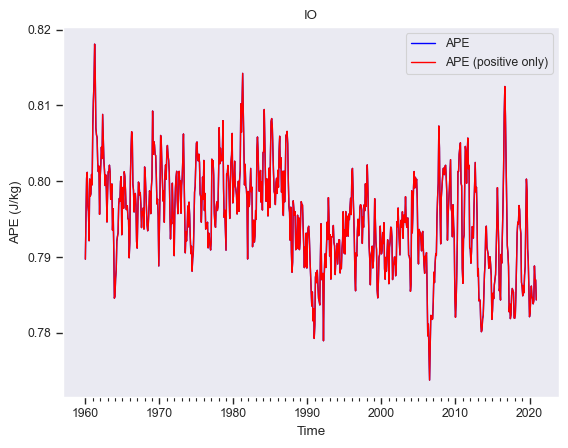

In [67]:
plt.plot(range(ncounter),APE_mean_time_series,'b',linewidth=1,label='APE')
plt.plot(range(ncounter),APE_bis_time_series,'r',linewidth=1,label='APE (positive only)')
#plt.gca().set_ylim(3.38,3.47)
#plt.gca().invert_yaxis()
plt.legend(loc='best')
plt.ylabel('APE (J/kg)')
plt.xlabel('Time') 
plt.title(ocean)
plt.xticks(np.arange(0, ncounter, 120), labels = np.arange(start_year, end_year+1, 10))
plt.xticks(ticks=np.arange(0, ncounter, 12), labels=None, minor=True)
plt.savefig(f'APE_{ocean}')

plt.show()

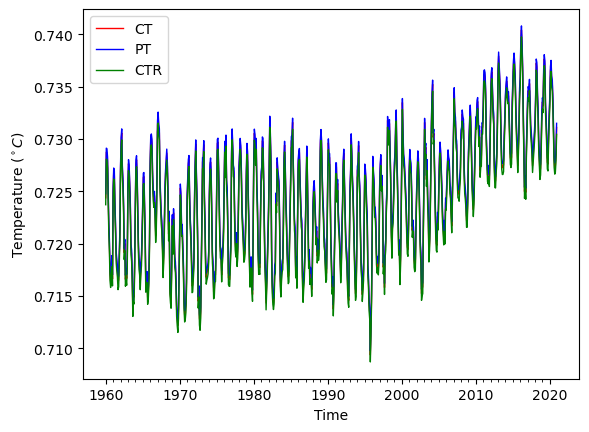

In [37]:
plt.plot(range(ncounter),CT_mean_time_series,'r',linewidth=1,label='CT')
plt.plot(range(ncounter),PT_mean_time_series,'b',linewidth=1,label='PT')
plt.plot(range(ncounter),CTR_mean_time_series,'g',linewidth=1,label='CTR') 
# plt.gca().set_ylim(3.38,3.47)
#plt.gca().invert_yaxis()
plt.legend(loc='best')
plt.ylabel('Temperature ($^\circ C$)')
plt.xlabel('Time') 
plt.savefig(f'Temp_{ocean}')
plt.xticks(np.arange(0, ncounter, 120), labels = np.arange(start_year, end_year+1, 10))
plt.xticks(ticks=np.arange(0, ncounter, 12), labels=None, minor=True)
plt.show()